# Cards Model Test

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from jass.train.label_play import LabelPlay
from jass.logs.game_log_entry import GameLogEntry
from jass.game.game_state_util import state_from_complete_game, calculate_starting_hands_from_game
from jass.game.rule_schieber import RuleSchieber
from examples.io.convert_swisslos_log_to_games import LogParserSwisslos

In [2]:
cards = [
# Diamonds
'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
# Hearts
'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
# Spades
'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
# Clubs
'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

user  = ['user']
trump = ['trump']
played_card  = ['played_card']

rule = RuleSchieber()

entries = []
path = Path("jass-games") / "jass_game_0001.txt"
with open(path) as file:
    line = file.readline()
    #while line:
    for x in range(1000):
        content = json.loads(line)
        entry = GameLogEntry.from_json(content)
        entries.append(entry)
        line = file.readline()

#entries = LogParserSwisslos.parse_rounds(path)

rows = []

for entry in entries:
    for nrCards in range(0,34):
        round_state = state_from_complete_game(entry.game, nrCards)
        valid_cards = rule.get_valid_cards_from_state(round_state)# valid cards for player
        row = valid_cards
        
        row = np.append(row, round_state.trump)
        
        next_round_state = state_from_complete_game(entry.game, nrCards + 1)
        #print(round_state.current_trick)
        #print(next_round_state.tricks[round_state.nr_tricks])
        card = np.setdiff1d(next_round_state.tricks[round_state.nr_tricks], round_state.current_trick)
        #print(card)
        row = np.append(row,card[0])
        rows.append(row)

data =pd.DataFrame(data=rows ,columns=cards + trump + played_card)

pd.set_option('display.max_columns', None)
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,HK,HQ,HJ,H10,H9,H8,H7,H6,SA,SK,SQ,SJ,S10,S9,S8,S7,S6,CA,CK,CQ,CJ,C10,C9,C8,C7,C6,trump,played_card
0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,9
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,14
2,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13
3,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,4
4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,30


## import player statistics

In [3]:
#stats = pd.read_json("04 Data/stat/player_all_stat.json")
#stats.head()

In [4]:
#stats.sort_values(by=['mean'], ascending=False)

# Drop bad players

In [5]:
#good_users = stats.loc[(stats['mean'] > 79) & (stats['nr'] > 5)]
#good_users

In [6]:
#data = data[data['user'].isin(good_users['id'])]
#data

# Training

In [7]:
from sklearn.model_selection import train_test_split
feature_columns = []


In [8]:
x_data = data[cards + trump + feature_columns]
y_data = data.played_card

In [9]:
X_train, X_test, y_train_data, y_test_data = train_test_split(x_data, y_data, test_size=0.2, stratify=data.played_card, random_state=42)

print(y_train_data)
#y_train_label = np.argmax(x_train, axis=1)
#y_categorical = tf.keras.utils.to_categorical(y_train_label, num_classes=4)

22073     7
30216     8
6398     35
13460     8
6082     32
         ..
9197     24
26809     6
2698      4
6441     26
6709     31
Name: played_card, Length: 27200, dtype: int64


In [10]:
y_train = pd.get_dummies(y_train_data)
y_test = pd.get_dummies(y_test_data)
print(y_train)

       0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
22073   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   
30216   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   
6398    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
13460   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   
6082    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
9197    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
26809   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
2698    0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
6441    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
6709    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

       18  19  20  21  22  

In [11]:
input_length = len(cards + trump + feature_columns)
print(input_length)


model = keras.Sequential()
model.add(keras.layers.Dense(input_length, activation='relu', input_shape=[input_length]))
#model.add(keras.layers.Dense(240, activation='relu'))
model.add(keras.layers.Dense(120, activation='relu'))
model.add(keras.layers.Dense(120, activation='relu'))
model.add(keras.layers.Dense(54, activation='relu'))
model.add(keras.layers.Dense(54, activation='relu'))
model.add(keras.layers.Dense(40, activation='relu'))
model.add(keras.layers.Dense(40, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(36, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.25, epochs=300, batch_size=100)

37
Epoch 1/300
204/204 [==============================] - 1s 3ms/step - loss: 3.5812 - accuracy: 0.0297 - val_loss: 3.5791 - val_accuracy: 0.0284
Epoch 2/300
204/204 [==============================] - 0s 2ms/step - loss: 3.5775 - accuracy: 0.0328 - val_loss: 3.5762 - val_accuracy: 0.0440
Epoch 3/300
204/204 [==============================] - 0s 2ms/step - loss: 3.5743 - accuracy: 0.0361 - val_loss: 3.5718 - val_accuracy: 0.0526
Epoch 4/300
204/204 [==============================] - 0s 2ms/step - loss: 3.5691 - accuracy: 0.0421 - val_loss: 3.5665 - val_accuracy: 0.0718
Epoch 5/300
204/204 [==============================] - 0s 2ms/step - loss: 3.5657 - accuracy: 0.0475 - val_loss: 3.5606 - val_accuracy: 0.0822
Epoch 6/300
204/204 [==============================] - 0s 2ms/step - loss: 3.5583 - accuracy: 0.0467 - val_loss: 3.5522 - val_accuracy: 0.0851
Epoch 7/300
204/204 [==============================] - 0s 2ms/step - loss: 3.5513 - accuracy: 0.0533 - val_loss: 3.5417 - val_accuracy: 0.0

Epoch 58/300
204/204 [==============================] - 0s 2ms/step - loss: 2.1287 - accuracy: 0.3739 - val_loss: 1.8757 - val_accuracy: 0.4416
Epoch 59/300
204/204 [==============================] - 0s 2ms/step - loss: 2.1232 - accuracy: 0.3805 - val_loss: 1.8630 - val_accuracy: 0.4390
Epoch 60/300
204/204 [==============================] - 0s 2ms/step - loss: 2.1153 - accuracy: 0.3746 - val_loss: 1.8502 - val_accuracy: 0.4399
Epoch 61/300
204/204 [==============================] - 0s 2ms/step - loss: 2.1073 - accuracy: 0.3850 - val_loss: 1.8499 - val_accuracy: 0.4404
Epoch 62/300
204/204 [==============================] - 0s 2ms/step - loss: 2.0998 - accuracy: 0.3868 - val_loss: 1.8581 - val_accuracy: 0.4451
Epoch 63/300
204/204 [==============================] - 0s 2ms/step - loss: 2.0894 - accuracy: 0.3907 - val_loss: 1.8609 - val_accuracy: 0.4410
Epoch 64/300
204/204 [==============================] - 0s 2ms/step - loss: 2.0891 - accuracy: 0.3858 - val_loss: 1.8395 - val_accuracy:

Epoch 115/300
204/204 [==============================] - 0s 2ms/step - loss: 1.9358 - accuracy: 0.4181 - val_loss: 1.7413 - val_accuracy: 0.4626
Epoch 116/300
204/204 [==============================] - 0s 2ms/step - loss: 1.9362 - accuracy: 0.4181 - val_loss: 1.7404 - val_accuracy: 0.4563
Epoch 117/300
204/204 [==============================] - 0s 2ms/step - loss: 1.9393 - accuracy: 0.4105 - val_loss: 1.7496 - val_accuracy: 0.4535
Epoch 118/300
204/204 [==============================] - 0s 2ms/step - loss: 1.9281 - accuracy: 0.4195 - val_loss: 1.7371 - val_accuracy: 0.4549
Epoch 119/300
204/204 [==============================] - 0s 2ms/step - loss: 1.9327 - accuracy: 0.4132 - val_loss: 1.7386 - val_accuracy: 0.4600
Epoch 120/300
204/204 [==============================] - 0s 2ms/step - loss: 1.9196 - accuracy: 0.4186 - val_loss: 1.7377 - val_accuracy: 0.4576
Epoch 121/300
204/204 [==============================] - 0s 2ms/step - loss: 1.9241 - accuracy: 0.4199 - val_loss: 1.7409 - val_ac

204/204 [==============================] - 0s 2ms/step - loss: 1.8568 - accuracy: 0.4291 - val_loss: 1.7028 - val_accuracy: 0.4641
Epoch 172/300
204/204 [==============================] - 0s 2ms/step - loss: 1.8529 - accuracy: 0.4276 - val_loss: 1.7145 - val_accuracy: 0.4628
Epoch 173/300
204/204 [==============================] - 0s 2ms/step - loss: 1.8465 - accuracy: 0.4317 - val_loss: 1.7013 - val_accuracy: 0.4613
Epoch 174/300
204/204 [==============================] - 0s 2ms/step - loss: 1.8473 - accuracy: 0.4300 - val_loss: 1.6963 - val_accuracy: 0.4687
Epoch 175/300
204/204 [==============================] - 0s 2ms/step - loss: 1.8425 - accuracy: 0.4312 - val_loss: 1.7037 - val_accuracy: 0.4668
Epoch 176/300
204/204 [==============================] - 0s 2ms/step - loss: 1.8458 - accuracy: 0.4332 - val_loss: 1.7012 - val_accuracy: 0.4687
Epoch 177/300
204/204 [==============================] - 0s 2ms/step - loss: 1.8438 - accuracy: 0.4334 - val_loss: 1.6986 - val_accuracy: 0.4613

204/204 [==============================] - 0s 2ms/step - loss: 1.7769 - accuracy: 0.4452 - val_loss: 1.6533 - val_accuracy: 0.4684
Epoch 228/300
204/204 [==============================] - 0s 2ms/step - loss: 1.7685 - accuracy: 0.4463 - val_loss: 1.6449 - val_accuracy: 0.4737
Epoch 229/300
204/204 [==============================] - 0s 2ms/step - loss: 1.7707 - accuracy: 0.4433 - val_loss: 1.6383 - val_accuracy: 0.4772
Epoch 230/300
204/204 [==============================] - 0s 2ms/step - loss: 1.7705 - accuracy: 0.4467 - val_loss: 1.6431 - val_accuracy: 0.4778
Epoch 231/300
204/204 [==============================] - 0s 2ms/step - loss: 1.7669 - accuracy: 0.4473 - val_loss: 1.6530 - val_accuracy: 0.4721
Epoch 232/300
204/204 [==============================] - 0s 2ms/step - loss: 1.7634 - accuracy: 0.4461 - val_loss: 1.6507 - val_accuracy: 0.4772
Epoch 233/300
204/204 [==============================] - 0s 2ms/step - loss: 1.7660 - accuracy: 0.4461 - val_loss: 1.6502 - val_accuracy: 0.4715

204/204 [==============================] - 0s 2ms/step - loss: 1.7035 - accuracy: 0.4601 - val_loss: 1.6329 - val_accuracy: 0.4769
Epoch 284/300
204/204 [==============================] - 0s 2ms/step - loss: 1.7085 - accuracy: 0.4610 - val_loss: 1.6353 - val_accuracy: 0.4696
Epoch 285/300
204/204 [==============================] - 0s 2ms/step - loss: 1.7090 - accuracy: 0.4587 - val_loss: 1.6330 - val_accuracy: 0.4718
Epoch 286/300
204/204 [==============================] - 0s 2ms/step - loss: 1.7124 - accuracy: 0.4567 - val_loss: 1.6326 - val_accuracy: 0.4735
Epoch 287/300
204/204 [==============================] - 0s 2ms/step - loss: 1.7066 - accuracy: 0.4578 - val_loss: 1.6261 - val_accuracy: 0.4784
Epoch 288/300
204/204 [==============================] - 0s 2ms/step - loss: 1.7038 - accuracy: 0.4590 - val_loss: 1.6278 - val_accuracy: 0.4772
Epoch 289/300
204/204 [==============================] - 0s 2ms/step - loss: 1.7034 - accuracy: 0.4588 - val_loss: 1.6319 - val_accuracy: 0.4768

In [12]:
model.evaluate(X_test, y_test)

213/213 [==============================] - 0s 2ms/step - loss: 1.5947 - accuracy: 0.4860


[1.5947365760803223, 0.48602941632270813]

Text(0, 0.5, 'loss')

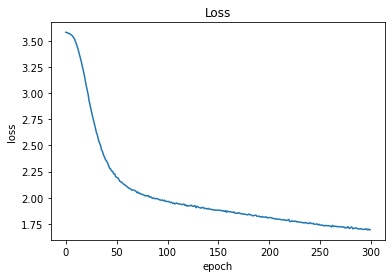

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

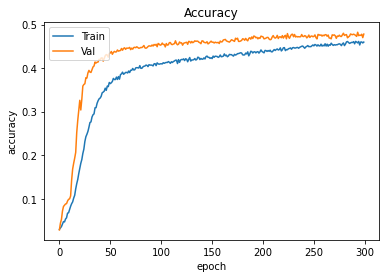

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

# Predict

In [15]:
def deal_random_hand() -> np.ndarray:
    """
    Deal random hand.

    Returns:
        one hot encoded 1x36 array
    """
    # shuffle card ids
    cards = np.arange(0, 36, dtype=np.int32)
    np.random.shuffle(cards)
    hands = np.zeros(shape=[4, 36], dtype=np.int32)

    # convert to one hot encoded
    hands[0, cards[0:9]] = 1
    hands[1, cards[9:18]] = 1
    hands[2, cards[18:27]] = 1
    hands[3, cards[27:39]] = 1
    
    hand = np.append(hands[0], np.random.randint(0,5))

    return hand

In [20]:
hand = deal_random_hand()
#hand = np.array([[0,1,1,1,0,1,0,0,0, 0,0,0,0,1,0,0,1,0, 1,0,0,0,0,0,0,0,0, 0,0,0,0,0,1,0,0,1, 4]])
hand_df = pd.DataFrame(data=[hand], columns=cards+trump)

print(hand_df)
print("\n")
input_hand = np.array([hand_df.iloc[0].values])
prediction = model.predict(input_hand)
prediction = prediction * hand[:-1]
result = pd.DataFrame(data=prediction, columns=cards)
print(result)
result.idxmax(axis=1)

   DA  DK  DQ  DJ  D10  D9  D8  D7  D6  HA  HK  HQ  HJ  H10  H9  H8  H7  H6  \
0   0   0   0   0    0   0   1   1   0   0   1   0   0    1   0   0   0   1   

   SA  SK  SQ  SJ  S10  S9  S8  S7  S6  CA  CK  CQ  CJ  C10  C9  C8  C7  C6  \
0   0   0   0   1    1   0   0   0   1   0   0   0   0    0   0   0   1   0   

   trump  
0      0  


    DA   DK   DQ   DJ  D10   D9        D8        D7   D6   HA        HK   HQ  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.339139  0.264168  0.0  0.0  0.002556  0.0   

    HJ       H10   H9   H8   H7        H6   SA   SK   SQ        SJ       S10  \
0  0.0  0.000238  0.0  0.0  0.0  0.000003  0.0  0.0  0.0  0.000113  0.001262   

    S9   S8   S7        S6   CA   CK   CQ   CJ  C10   C9   C8        C7   C6  
0  0.0  0.0  0.0  0.000024  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.001002  0.0  


0    D8
dtype: object

In [17]:
#model.save("D:/User/Fabio/dl4g-jass-bot/models/CardsModel05865")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: D:/User/Fabio/dl4g-jass-bot/models/CardsModel05865\assets
